In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import time
import pytz
import imutils
import hashlib
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from typing import List
from pathlib import Path
from imutils.video import VideoStream
from PIL import Image

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

### STEP 1

Load our preprocessed data back in.

In [2]:
npy_data = 'dataset/numpy_images.npy'
label_data = 'dataset/labels.pkl'
if Path(npy_data).is_file() and Path(label_data).is_file():
    print('Loading from previously processed training data X and labels Y')
    with open(npy_data, 'rb') as f:
        X = np.load(f)
    with open(label_data, 'rb') as f:
        Y = pickle.load(f)
        labels = [label_map[e] for e in Y]
else:
    print('No training numpy array saved previously. Please run the preprocessing notebook.')


assert X.shape == (32298, 48, 48, 1)
print(f'Validated that X.shape is (32298, 48, 48, 1)')

assert len(Y) == X.shape[0]
print(f'Validated that len(Y) is {len(Y)}')

Loading from previously processed training data X and labels Y
Validated that X.shape is (32298, 48, 48, 1)
Validated that len(Y) is 32298


Let's see some samples images again to remind ourselves what data we are working with

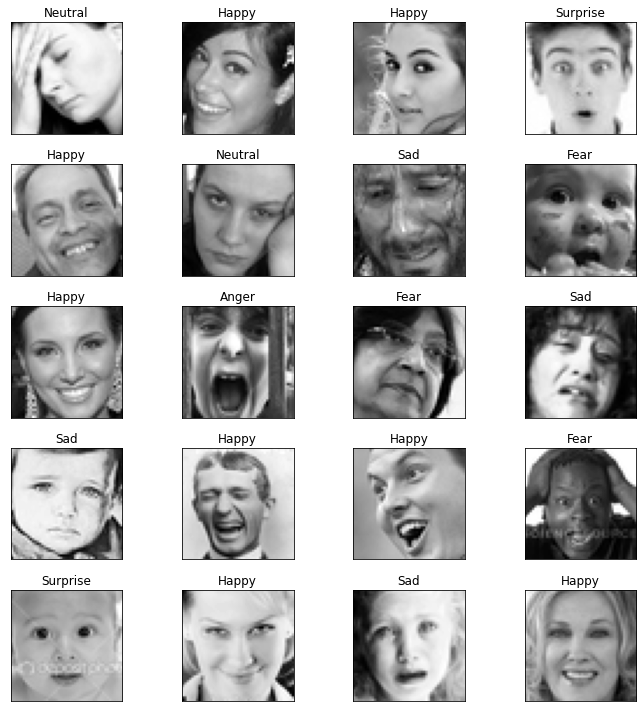

In [3]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    # Randomly choose an image, img_id should be a random integer going from 0, up to a total number of images in X
    img_id = np.random.choice(X.shape[0])
    
    # Select the numpy array corresponding to the index that is randomly chosen
    img = X[img_id, :, :, 0]
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Add the emotion label for the selected image as the title
    plt.title(labels[img_id])

fig.tight_layout()
plt.show()

Rerun train / test split before we being training


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=0)

Please check each of the variables shapes to ensure they are reaonsable.

## Define Model and Train on a Conv-Net

In [5]:
def simple_convnet():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    optim = tf.keras.optimizers.Adam(learning_rate=2e-4)
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
    
    return model

model = simple_convnet()
# model.summary()

In [6]:
image_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.0,  # set range for random zoom
    channel_shift_range=0.0,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode="nearest",
    cval=0.0,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format="channels_last",
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0,
)
image_generator = image_generator.flow(X_train, y_train, batch_size=64)

val_generator = ImageDataGenerator()
val_generator = val_generator.flow(X_val, y_val, batch_size=64)

In [16]:
utc_now = pytz.utc.localize(datetime.utcnow())
date_today = utc_now.astimezone(pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d')
path_model=f'checkpoints/convnet/{date_today}/' + '{epoch:02d}-{val_loss:.6f}.hdf5'
Path(f'checkpoints/convnet/{date_today}').mkdir(parents=True, exist_ok=True)
h = model.fit(
    x=image_generator, 
    steps_per_epoch=len(X_train) // 64,
    epochs=2, 
    verbose=1, 
    validation_data=val_generator,
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
        EarlyStopping(patience=15),
        ReduceLROnPlateau(patience=6, factor=0.3)
    ]
)

Epoch 1/2
454/454 [==============================] - 589s 1s/step - loss: 1.3580 - accuracy: 0.4800 - val_loss: 1.5378 - val_accuracy: 0.4390 - lr: 2.0000e-04
Epoch 2/2
454/454 [==============================] - 517s 1s/step - loss: 1.2429 - accuracy: 0.5289 - val_loss: 1.2321 - val_accuracy: 0.5406 - lr: 2.0000e-04


In [18]:
print(date_today)
print(path_model)

2020-08-05
checkpoints/convnet/2020-08-05/{epoch:02d}-{val_loss:.6f}.hdf5


## Evaluate Model

In [15]:
loss, acc = model.evaluate(X_val, y_val, verbose=1)
print(acc)

101/101 [==============================] - 11s 112ms/step - loss: 1.3632 - accuracy: 0.4740
0.47399380803108215


In [9]:
img_id = np.random.choice(X_val.shape[0])
print(img_id)
print(X_val.shape)
print(y_val.iloc[img_id])


72
(3230, 48, 48, 1)
3


## Example predictions

3 : Happy
4 : Sad
3 : Happy
3 : Happy
4 : Sad
3 : Happy
6 : Neutral
4 : Sad
6 : Neutral
3 : Happy
3 : Happy
6 : Neutral
3 : Happy
0 : Anger
3 : Happy
4 : Sad
3 : Happy
6 : Neutral
2 : Fear
6 : Neutral


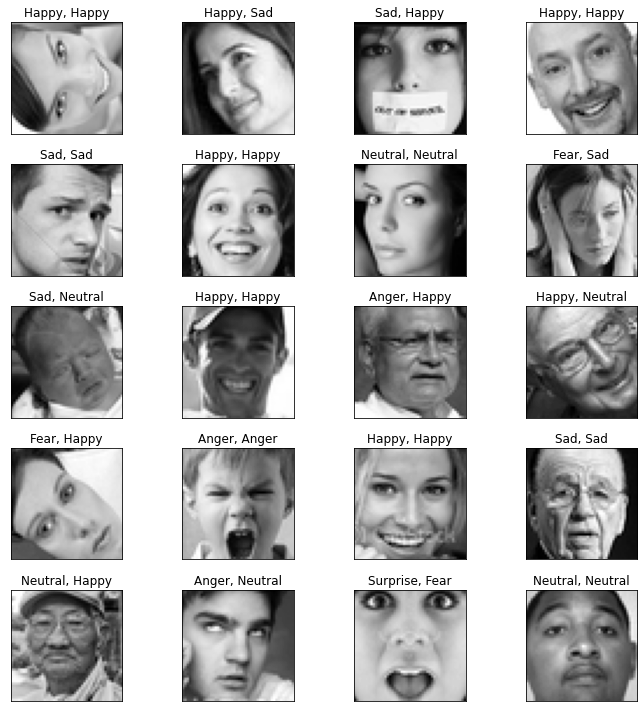

In [10]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
preds = model.predict(X_val)
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X_val.shape[0])
    img = X_val[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    print(np.argmax(preds[img_id]), ':', label_map[np.argmax(preds[img_id])])
    plt.title(f"{label_map[y_val.iloc[img_id]]}, {label_map[np.argmax(preds[img_id])]}")
fig.tight_layout()
plt.show()

## Error Analysis - TODO

Confusion Matrix
[[ 60   0  30  87 106  15 144]
 [  2   1   6   8   9   1  15]
 [ 22   0 103  82 106  29 126]
 [  5   0  21 669  40   8  46]
 [ 16   0  34 111 220   8 189]
 [  7   0  72  46  31 167  44]
 [ 10   0  26  93 100   4 311]]
Classification Report
              precision    recall  f1-score   support

       Anger       0.49      0.14      0.21       442
     Disgust       1.00      0.02      0.05        42
        Fear       0.35      0.22      0.27       468
       Happy       0.61      0.85      0.71       789
         Sad       0.36      0.38      0.37       578
    Surprise       0.72      0.46      0.56       367
     Neutral       0.36      0.57      0.44       544

    accuracy                           0.47      3230
   macro avg       0.56      0.38      0.37      3230
weighted avg       0.49      0.47      0.45      3230



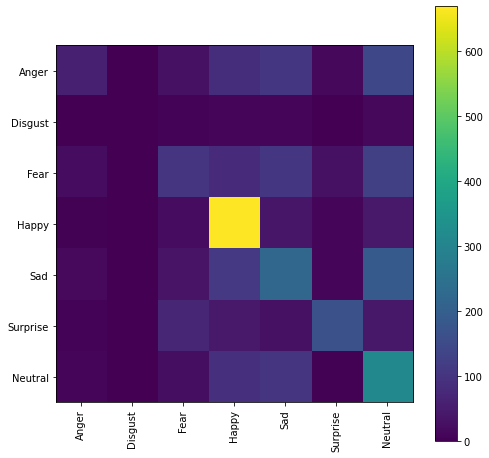

In [11]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes = list(label_map)
y_pred_label = np.argmax(preds, axis=1)

# Confusion Matrix and Classification Report

print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred_label))
print('Classification Report')
target_names = list(label_map)
print(classification_report(y_val, y_pred_label, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(y_val, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)